Steel model definition, with Dirichlet priors.

In [2]:
from steel_processes import define_processes
processes = define_processes()

In [3]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import theano
theano.config.mode = 'FAST_RUN'
theano.config.optimizer = 'fast_compile'

Maximum values of inputs:

In [4]:
input_defs = {
    'BF': 5000,
    'DR': 300,
    'SP': 1000,
    'IFC': 300,
}

In [5]:
import pickle
from priors import param_defs
from leontief_model import SplitParamModel

In [6]:
model1 = SplitParamModel(processes, input_defs, param_defs)

In [7]:
with open('model1.pickle', 'wb') as f:
    pickle.dump(model1, f, protocol=pickle.HIGHEST_PROTOCOL)

In [8]:
import pymc3 as pm
RANDOM_SEED = 974067  # from random.org

In [10]:
with model1.model:
    advi1 = pm.variational.advi(n=10000, random_seed=RANDOM_SEED)
np.savez('traces/advi1.npz', advi1)

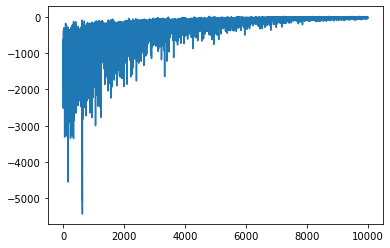

In [11]:
plt.plot(advi1.elbo_vals[0:]);

In [12]:
def sample(model, advi, trace=None, num_samples=2000):
    step = pm.NUTS(scaling=model.dict_to_array(advi.stds)**2, is_cov=True)
    trace = pm.sample(num_samples, start=advi.means, step=step, trace=trace)
    return trace

In [33]:
with model1.model:
    trace1 = sample(model1.model, advi1, trace=pm.backends.Text('traces/trace1'))

100%|██████████| 2000/2000 [02:40<00:00, 12.44it/s]


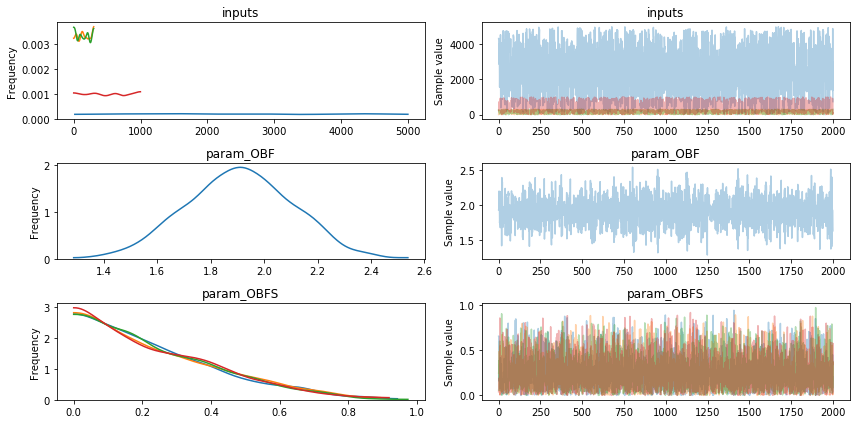

In [14]:
pm.traceplot(trace1, varnames=['inputs', 'param_OBF', 'param_OBFS']);

## Add observations

In [15]:
observations1 = [
        (['BF'], ['PI'], 928.4, 50),  # worldsteel: Table 41 - total pig iron
        (['DR'], ['DRI'], 65.8, 6),   # worldsteel: Table 42 - total DRI
        
        (['EAF'], ['EAFS'], 407.0, 40),  # worldsteel: Table 6 - EAF crude steel production
        (['OBF'], ['OBFS'], 891.7, 80),  # worldsteel: Table 6 - OBC crude steel production
        (['OHF'], ['OHFS'], 29.3, 3),    # worldsteel: Table 6 - OHF + other crude steel production
        
        # SEM output, from worldsteel
        (['SEMP'], ['seclight'], 44.4, 2),    # Cullen flow [105]: worldsteel table 16
        (['SEMP'], ['secheavy'], 39.6, 2),    # Cullen flow [106]: worldsteel table 15
        (['SEMP'], ['secrail'], 10.0, 1),     # Cullen flow [107]: worldsteel table 14
        
        # RBM output, from worldsteel
        (['STP'], ['seamlesstube'], 27.2, 2), # Cullen flow [85]: worldsteel table 25
        (['RBMP'], ['rodrebar'], 147.0, 15),  # Cullen flow [108]: worldsteel table 17 (he added extra 26.6 to make it add up)
        (['RBMP'], ['rodwire'], 148.5, 15),   # Cullen flow [109]: worldsteel table 19
        (['RBMP'], ['rodbar'], 109.7, 11),    # Cullen flow [110]: worldsteel table 18
        
        # PLM output, from worldsteel & others
        (['TWP'], ['weldedtube'], 44.5, 4),   # Cullen flow [89]: worldsteel table 26. (he solved as 62.4 to make "apparent consumption" match)
        (['PLMP'], ['plate'], 110.0, 11),     # Cullen flow [111]: SBB value (ref 14, p4)
        
        # HSM output, from worldsteel & SBB
        (['CRMP'], ['elsheet'], 10.3, 2),      # Cullen flow [112]: worldsteel table 20
        (['CRMP'], ['crc'], 135.0, 13),        # Cullen flow [113]: SBB (ref 14, p4)
        (['GPP_CR'], ['crcgalv'], 96.4, 9),    # Cullen flow [114]: worldsteel table 22 (assumed all CRC)
        (['HSMP'], ['hrc'], 150.0, 15),        # Cullen flow [115]: SBB (ref 14, p4)
        (['HSMP'], ['hrns'], 40.0, 4),         # Cullen flow [116]: SBB (ref 14, p4)
        (['GP_HR'], ['hrcgalv'], 10.0, 2),     # Cullen flow [97]: SBB (ref 14, p4)
        (['TM'], ['crctinned'], 11.6, 2),      # Cullen flow [100]: worldsteel table 21 (all tinmill)
        (['OCP'], ['crccoated'], 16.5, 2),     # Cullen flow [103]: worldsteel table 23 (all non-metalic coated)
]

In [16]:
model2 = SplitParamModel(processes, input_defs, param_defs, flow_observations=observations1)

In [17]:
with open('model2.pickle', 'wb') as f:
    pickle.dump(model2, f, protocol=pickle.HIGHEST_PROTOCOL)

In [18]:
with model2.model:
    advi2 = pm.variational.advi(n=10000)
np.savez('traces/advi2.npz', advi2)    

Average ELBO = -544.51: 100%|██████████| 10000/10000 [00:46<00:00, 214.51it/s]
Finished [100%]: Average ELBO = -473.23


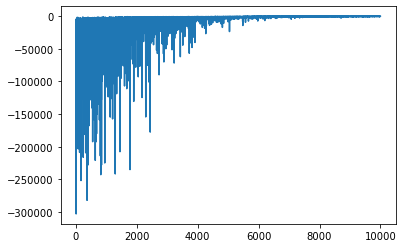

In [19]:
plt.plot(advi2.elbo_vals[0:]);

In [20]:
with model2.model:
    trace2 = sample(model2.model, advi2, trace=pm.backends.Text('traces/trace2'), num_samples=500)

100%|██████████| 500/500 [55:10<00:00,  6.62s/it]  


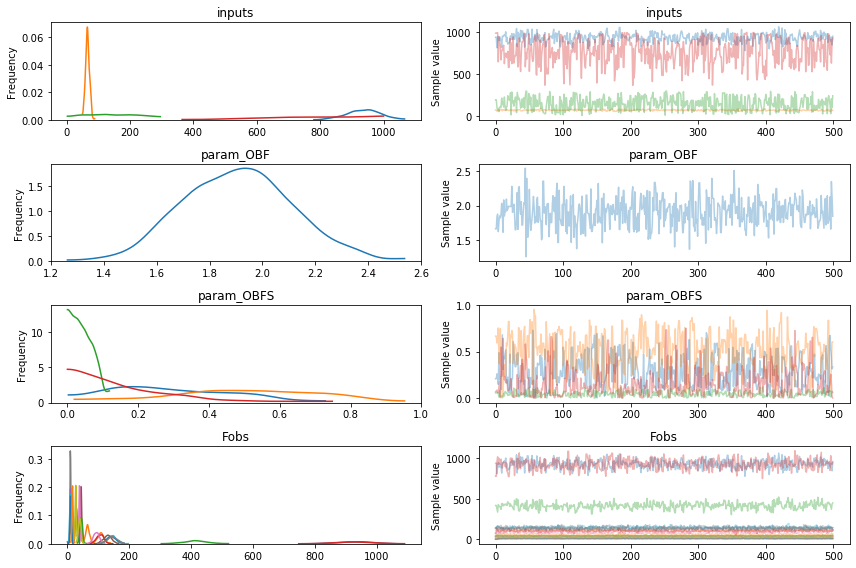

In [21]:
pm.traceplot(trace2, varnames=['inputs', 'param_OBF', 'param_OBFS', 'Fobs']);

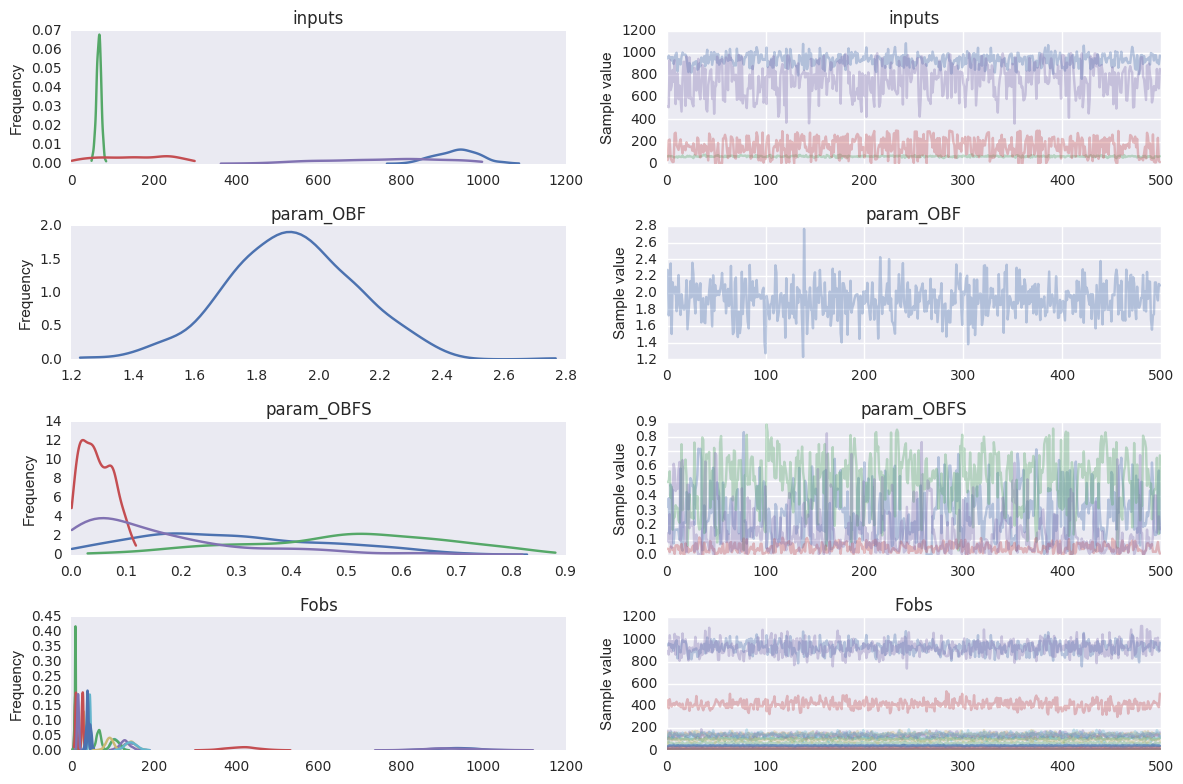

In [49]:
pm.traceplot(trace2, varnames=['inputs', 'param_OBF', 'param_OBFS', 'Fobs']);

Next data points to add:
- Cullen flow [57]: cast iron product. 54 - scrap. 55 - pig iron. 56 - other scrap. 59 - loop
- scrap steel input [53] should be 17% of inputs, from considering the dilution. need another observation type?
- pig iron to casting is [5] - [12] - [16] - [20], ie. [bf output] - [EAF, OBF, OHF use]
- pig iron to EAF is observed [12]
- pig iron to OBF [16] comes from yield and scrap input. Scrap is what's left from [10]-[13]-[54].
- pig iron to OHF [20] is well defined since there's no scrap input
- scrap to OBF is [scrap prepared]-[scrap to EAF: observed]-[scrap to casting: from concentrations]
- scrap prepared [10] is given by forming scrap [8] and observed other input. Until I include fabrication scrap, this needs to be an input observation?

Summary:
- add pig iron to EAF observation [12]
- add scrap input observation [10]
- add cast iron production [57]
- add cast iron scrap input fraction = 17%
- add steel casting production [51]

In [22]:
observations2 = observations1 + [
    (['PI'], ['EAF'], 44.6, 4),   # Cullen flow [12] (ref 2)
    (['SPC'], ['caststeel'], 10.5, 2),    # Cullen flow [51], from ref (11)
    (['IFC'], ['castiron'], 68.3, 6),     # Cullen flow [57], from ref (11)
]

input_observations = [
    (['SP'], 475.5, 40),     # Cullen flow [10]; change if fabrication scrap is added
]

inflow_fraction_observations = [
    (['S'], ['IFC'], 0.17, 0.03),         # Cullen flow [54] -- scrap is 17%.
    # Should be relative to cast iron output, not process throughput.
]

In [23]:
model3 = SplitParamModel(processes, input_defs, param_defs,
                         flow_observations=observations2,
                         input_observations=input_observations,
                         inflow_observations=inflow_fraction_observations)

In [24]:
with open('model3.pickle', 'wb') as f:
    pickle.dump(model3, f, protocol=pickle.HIGHEST_PROTOCOL)

In [25]:
with model3.model:
    advi3 = pm.variational.advi(n=10000)
np.savez('traces/advi3.npz', advi3)

Average ELBO = -854.99: 100%|██████████| 10000/10000 [00:49<00:00, 201.09it/s]
Finished [100%]: Average ELBO = -675.83


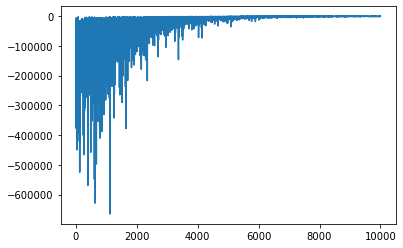

In [26]:
plt.plot(advi3.elbo_vals[0:]);

In [27]:
with model3.model:
    trace3 = sample(model3.model, advi3, trace=pm.backends.Text('traces/trace3'), num_samples=500)

100%|██████████| 500/500 [1:16:56<00:00,  9.23s/it]


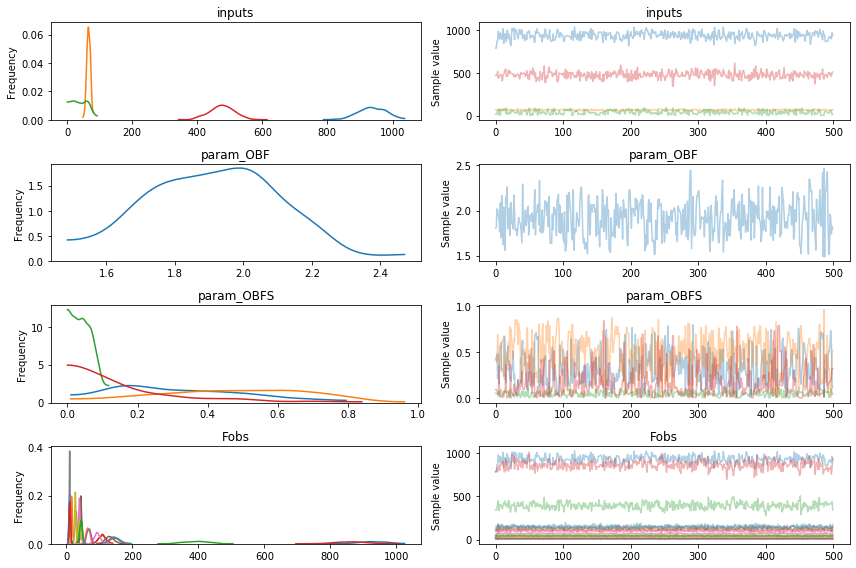

In [28]:
pm.traceplot(trace3, varnames=['inputs', 'param_OBF', 'param_OBFS', 'Fobs']);